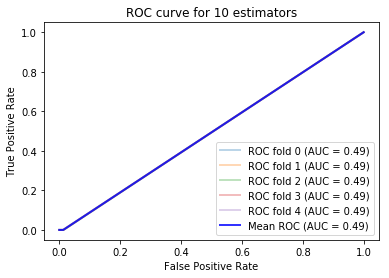

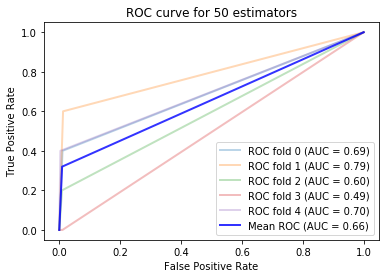

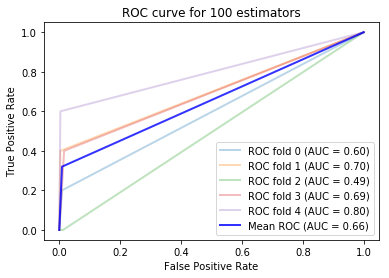

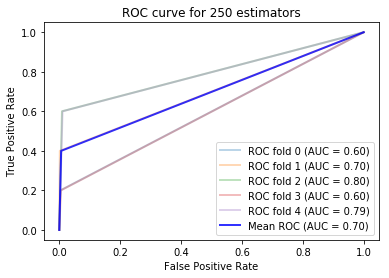

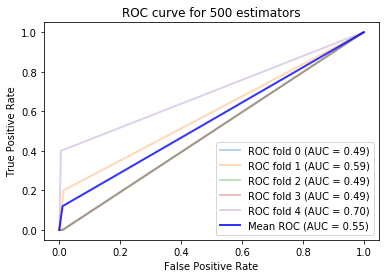

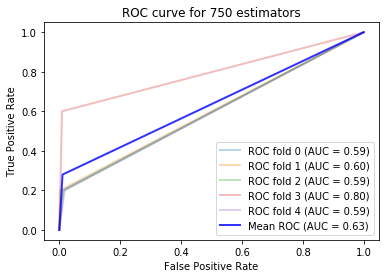

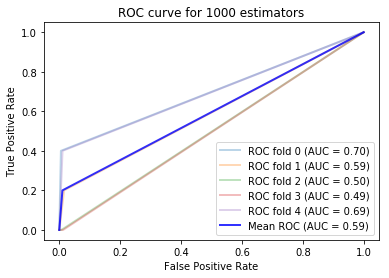

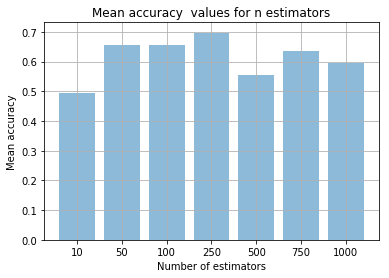

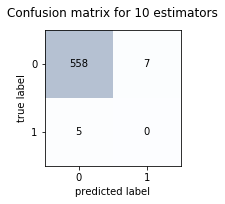

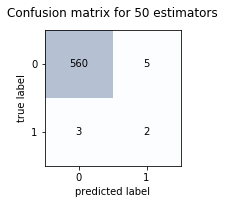

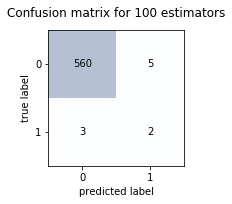

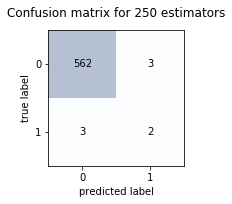

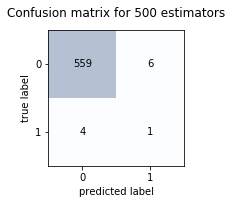

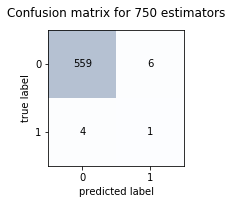

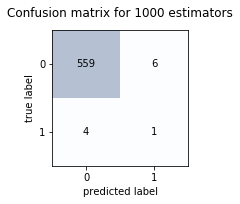

In [4]:
import pandas as pd
import numpy as np
from scipy import interp
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from mlxtend.plotting import plot_confusion_matrix



train = pd.read_csv('/Users/karolinasg/Documents/python-course/Python_project_UU/exoTrain.csv', sep=',', low_memory=False)
test = pd.read_csv('/Users/karolinasg/Documents/python-course/Python_project_UU/exoTest.csv', sep=',', low_memory=False)
# training set - features
X_train = train.iloc[:,1:]
#  training set - decisions
y_train = train['LABEL']
#test set - features
X_test = test.iloc[:,1:]
#  training set - decisions
y_test = test['LABEL']


#y_test[y_test == 1 ] = 0
y_test = y_test.replace(1, 0)
y_test = y_test.replace(2, 1)
#y_test[y_test == 2 ] = 1
y_train = y_train.replace(1, 0)
y_train = y_train.replace(2, 1)
#y_train[y_train == 1 ] = 0
#y_train[y_train == 2 ] = 1


#########################

#data preprocessing
#Range data 0-1
#min_max_scaler = preprocessing.MinMaxScaler()
#X_train_minmax = min_max_scaler.fit_transform(X_train_scal)
#X_test_minmax = min_max_scaler.transform(X_test_scal)

#normalization
normalizer = preprocessing.Normalizer().fit(X_train)  
X_train_norm = normalizer.transform(X_train) 
X_test_norm = normalizer.transform(X_test) 


#predict function
def ExoplanetFunction(n_estimator):
    #creating classifier 
    clf = DecisionTreeClassifier()
    #strong imbalance classes - using the Boost method
    clf_model = AdaBoostClassifier(clf,  n_estimators= n_estimator)

    tprs = []
    fprs = []
    aucs= []
    precisions = []
    recalls = []
    average_precision = []
    tns = []
    fps = [] 
    fns = []
    tps = []

    #number of iteration
    n = 5
    for i in range(n):
        #print(i)
        probas = []
        probas = clf_model.fit(X_train_norm,y_train).predict_proba(X_test_norm)
        #roc curve 
        fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1])
        fprs.append(fpr)
        tprs.append(tpr)
        #auc value
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #printing a confusion matrix
        #print(confusion_matrix(y_test, clf_model.predict(X_test_norm)))
        tn, fp, fn, tp = confusion_matrix(y_test, clf_model.predict(X_test_norm)).ravel()
        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
        tps.append(tp)
        plt.plot(fpr, tpr, lw=2, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        #Precision recall curve 
        precision, recall, thresholds2 = precision_recall_curve(y_test, probas[:, 1])
        precisions.append(precision)
        recalls.append(recall)
        average_precision.append(average_precision_score(y_test, probas[:, 1]))


    mean_tpr = np.mean(tprs, axis=0)
    mean_fpr = np.mean(fprs, axis=0)
    mean_auc = np.mean(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label='Mean ROC (AUC = %0.2f)' % (mean_auc),
             lw=2, alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for %d estimators' % (n_estimator))
    plt.legend(loc = "lower right")
    plt.show()


    #confusion matrix mean
    mean_tn = np.around(np.mean(tns), decimals = 0)
    mean_fp = np.around(np.mean(fps), decimals = 0)
    mean_fn = np.around(np.mean(fns), decimals = 0)
    mean_tp = np.around(np.mean(tps), decimals = 0)

    binary = np.array([[mean_tn, mean_fp],
                       [mean_fn, mean_tp]])


    return  binary.astype(int), mean_auc




#Tested a different number of estimaters: 10, 100, 1000

#n_estimator=10
n_estimator = [10,50, 100, 250, 500,750,1000]
#n_estimator = [100]


mean_aucs = []
binaries = []
for i in n_estimator:
    binary, mean_auc = ExoplanetFunction(i)
    mean_aucs.append(mean_auc)
    binaries.append(binary)




#Plots - Mean accuracy 
    
y_pos = np.arange(len(n_estimator ))
plt.bar(y_pos, mean_aucs, align='center', alpha=0.5)
plt.xticks(y_pos, n_estimator)
plt.xlabel('Number of estimators')
plt.ylabel('Mean accuracy')
plt.title('Mean accuracy  values for n estimators')
plt.grid()
plt.show()


#Mean Confusion matrices
counter=0
for j in binaries:
    fig, ax = plot_confusion_matrix(conf_mat=j)
    plt.title('Confusion matrix for %d estimators' % n_estimator[counter] )
    
    counter=counter+1
    plt.show()

